In [367]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
#print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [386]:
plt.rcParams.update({'figure.figsize':(18,10), 'figure.dpi':120})

# function to plot results
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

# function to calc RMSE and R^2; and also plot results
def eval_results(y, yhat, y_scaler = None, plot=True):
    if y_scaler != None:
        yhat = y_scaler.inverse_transform(np.array(yhat).reshape(-1,1)).flatten()
        
    print("RMSE: ", mean_squared_error(y, yhat, squared = False))
    print("R^2: ", r2_score(y, yhat))

    if plot:
        plt.figure(figsize = (20,10))
        plot_series(np.arange(len(y)), y)
        plot_series(np.arange(len(yhat)), yhat)

In [387]:
df = pd.read_csv(r'HourlyElectricityLoad.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)
df.drop_duplicates(subset=["dt"], keep='first', inplace=True)


In [388]:
def add_datepart(df1, fldname):
    fld = df1[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df1[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    for n in ('Month', 'Week','Dayofweek', 
            'Dayofyear'):
        df1[n] = getattr(fld.dt,n.lower())

In [389]:
from prophet import Prophet

split_time = len(df)-168

df_prophet = df[:split_time]
df_prophet.columns=["ds","y"]

#series['y'] = series['y'].astype(float)
m = Prophet()
m.fit(df_prophet)


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing


In [390]:
future = m.make_future_dataframe(periods=168, freq='H')

prophet_forecast = m.predict(future)

In [391]:
add_datepart(df, "dt" )
df

/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_71660/2697841306.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df1[n] = getattr(fld.dt,n.lower())


,dt,Load,Month,Week,Dayofweek,Dayofyear
0,2000-01-01 01:00:00,5700,1,52,5,1
1,2000-01-01 02:00:00,5555,1,52,5,1
2,2000-01-01 03:00:00,5440,1,52,5,1
3,2000-01-01 04:00:00,5318,1,52,5,1
4,2000-01-01 05:00:00,5276,1,52,5,1
...,...,...,...,...,...,...
113946,2019-12-31 19:00:00,10505,12,1,1,365
113947,2019-12-31 20:00:00,10309,12,1,1,365
113948,2019-12-31 21:00:00,10120,12,1,1,365
113949,2019-12-31 22:00:00,9954,12,1,1,365


In [430]:
resid = pd.DataFrame({"load":df.Load.values - prophet_forecast.yhat.values})

In [435]:
series =  resid.values

scaler = StandardScaler()
scaler = scaler.fit(series[:split_time].reshape(-1,1))
normalized = scaler.transform(series.reshape(-1,1))

V = df[['Dayofweek','Dayofyear']]

scaler1 = StandardScaler()
scaler1 = scaler1.fit(V[:split_time].values)
normalized1 = scaler1.transform(V.values)

In [450]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df=None,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=256,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [451]:
X = pd.DataFrame(normalized1, columns = ['Dayofweek','Dayofyear'])
X["Load"] = normalized

split_time = len(df)-24*365
split_time2 = len(df)-24*7

x_train = X[:split_time]
x_valid = X[split_time:split_time2]

In [452]:
wide_window = WindowGenerator(
    input_width=168, label_width=168, shift=168, train_df=x_train, val_df=x_valid,
    label_columns=["Load"])

wide_window.train

<MapDataset element_spec=(TensorSpec(shape=(None, 168, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 168, 1), dtype=tf.float32, name=None))>

In [453]:
tf.keras.backend.clear_session()
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss='mse',#tf.keras.losses.Huber()
                optimizer=tf.optimizers.Adam(), 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=50,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

lstm_model = tf.keras.models.Sequential([
    #tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(units=168)
])

history = compile_and_fit(lstm_model, wide_window, 2)

Epoch 1/50


2022-12-28 16:49:46.212735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 16:49:46.416992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 16:49:46.985144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


650/650 [==============================] - ETA: 0s - loss: 0.8197 - root_mean_squared_error: 0.9054

2022-12-28 16:50:18.825288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 16:50:18.876921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


650/650 [==============================] - 36s 51ms/step - loss: 0.8197 - root_mean_squared_error: 0.9054 - val_loss: 0.9835 - val_root_mean_squared_error: 0.9917
Epoch 2/50
650/650 [==============================] - 31s 47ms/step - loss: 0.7571 - root_mean_squared_error: 0.8701 - val_loss: 0.9215 - val_root_mean_squared_error: 0.9600
Epoch 3/50
650/650 [==============================] - 32s 49ms/step - loss: 0.7416 - root_mean_squared_error: 0.8612 - val_loss: 0.9531 - val_root_mean_squared_error: 0.9763
Epoch 4/50
650/650 [==============================] - 31s 47ms/step - loss: 0.8126 - root_mean_squared_error: 0.9014 - val_loss: 0.8943 - val_root_mean_squared_error: 0.9457
Epoch 5/50
650/650 [==============================] - 31s 47ms/step - loss: 0.7888 - root_mean_squared_error: 0.8881 - val_loss: 0.8663 - val_root_mean_squared_error: 0.9308
Epoch 6/50
650/650 [==============================] - 31s 47ms/step - loss: 0.7715 - root_mean_squared_error: 0.8783 - val_loss: 0.8509 - val

RMSE:  258.28507329511916
R^2:  0.6364151401838118


/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_71660/3624077533.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format)


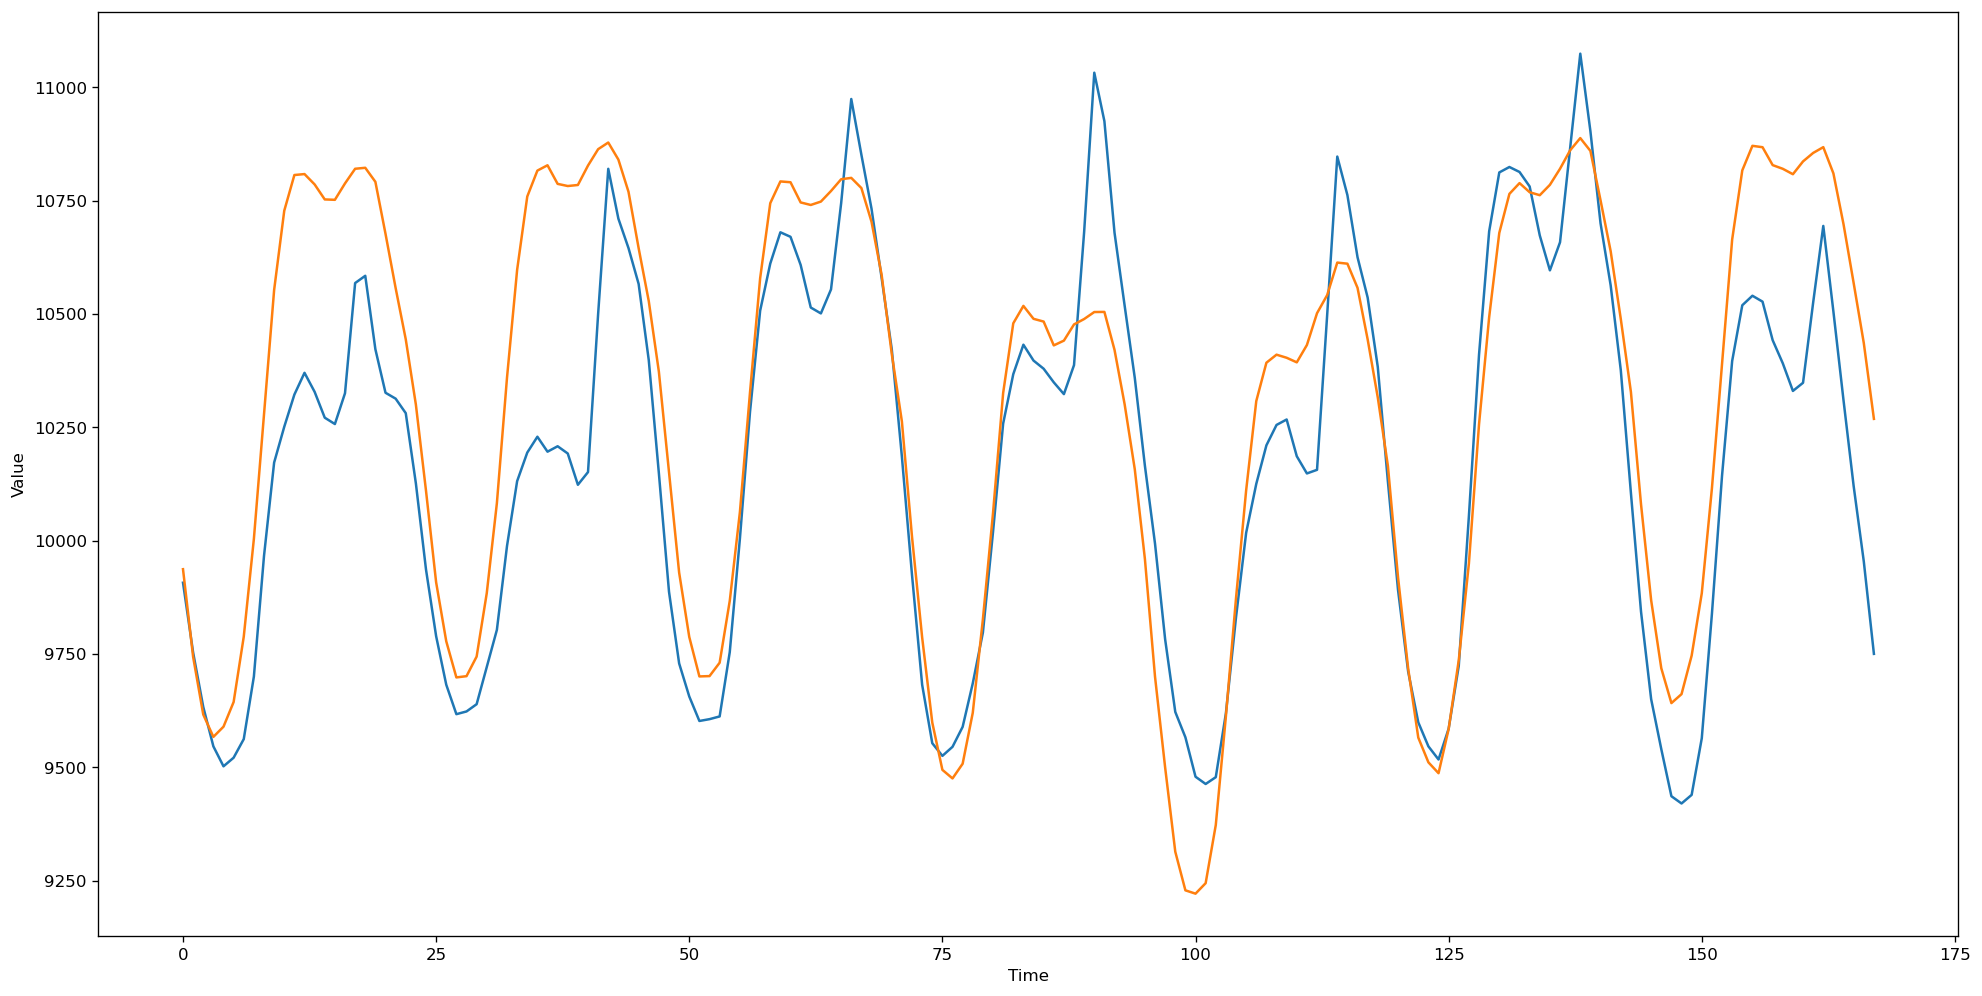

In [454]:
forecast = lstm_model(np.array(X[split_time2 - wide_window.input_width:split_time2])[np.newaxis], training=False)
results = np.array(forecast).flatten()
results1 = scaler.inverse_transform(results.reshape(-1,1)).flatten()+prophet_forecast["yhat"][split_time2:]
eval_results(raw_valid, results1, y_scaler=None)